<a href="https://colab.research.google.com/github/thdgmltjd123/Assignment01/blob/master/20150711_Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#구글 드라이브와 코랩 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np

file_data   = "/content/drive/My Drive/Colab Notebooks/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

X_train = list_image[:,:1000]
Y_train = list_label[:1000]
X_test = list_image[:,1000:]
Y_test = list_label[1000:] 

In [69]:
print(X_train.shape,Y_train.shape)

(784, 1000) (1000,)


In [0]:
#초기 값 세타들 만들기
def make_parameter(dim1, dim2):
  matrix = np.empty((dim1,dim2),dtype = float)
  for i in range(dim1):
    sd = np.random.randint(1,4)
    for j in range(dim2):
      matrix[i][j] = np.random.normal(0,sd)
  return matrix

# 시그모이드
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# 미분한 시그모이드
def diff_sigmoid(sigmoid):
  return sigmoid * (1 - sigmoid)

#이미지 값에 편향 더해주는 함수
def add_bias(data):
  col_len = data.shape[1]
  bias = np.ones((1,col_len),dtype = float)
  data = np.append(bias,data,axis = 0)
  return data

#라벨을 원핫 인코딩 하기
def one_hot(label):
  label_length = len(label)
  num_label = len(np.unique(label))
  matrix = np.empty((num_label,label_length), dtype = int)
  
  for i in range(label_length):
    for j in range(num_label):
      if(j == label[i]):
        matrix[j][i] = 1
      else:
        matrix[j][i] = 0
  return matrix

#에너지 함수
def energy(last_layer_sigmoid, onehot_label,theta_li, param_regul):
  hap = 0
  length = 0
  for i in theta_li:
    length += i.shape[0]*i.shape[1]
    hap += np.sum(i**2)
  return np.mean(np.sum(-onehot_label*np.log(last_layer_sigmoid+1e-9)-(1-onehot_label)*np.log(1-last_layer_sigmoid+1e-9),axis = 0)) + (param_regul * hap) / (2*length)

#예측함수  
def predict(X,theta_li):
  pred = np.empty(X.shape[1],dtype = int)
  for i in theta_li:
    bias_X = add_bias(X)
    X = np.dot(i,bias_X)
    X = sigmoid(X)
  
  pred = np.argmax(X,axis = 0)
  return pred

#정확도 함수
def accuracy(Y_pred, label):
  return np.mean(Y_pred == label)

#학습 함수
def fit(X, X_test, Y, Y_test, theta_li, alpha,param_regul):
  #return 시 필요한 array 생성
  train_energy_val = []
  test_energy_val = []
  train_accu_val = [0]
  test_accu_val = [0]
  length = X.shape[1]
  #반복 수 1만회
  epoch = 10000
  #진행상황을 알려주는 변수
  count = 1
  for k in range(epoch):
    if(k!=0 and k%250 == 0):
      print("{}% 완료".format(2.5*count))
      count+=1
    #원본 보존하기
    temp_X = X.copy()
    test_X = X_test.copy()
    #gradient descent를 위한 각 층별 결과물을 저장하는 리스트
    xyz_li = []
    #forward propagation(train, test)
    for i in theta_li:
      bias_X = add_bias(temp_X)
      test_bias_X = add_bias(test_X)
      temp_X = np.dot(i,bias_X)
      test_X = np.dot(i,test_bias_X)
      temp_X = sigmoid(temp_X)
      test_X = sigmoid(test_X)
      xyz_li.append(temp_X)
    
    #energy 계산을 위해 label을 onehot-encoding 실시
    onehot_label = one_hot(Y)
    tonehot_label = one_hot(Y_test)
    temp_energy = energy(temp_X, onehot_label,theta_li, param_regul)
    test_energy = energy(test_X, tonehot_label,theta_li, param_regul)
    train_energy_val.append(temp_energy)
    test_energy_val.append(test_energy)

    #backward propagation
    n = 0
    for i in theta_li:
      n += i.shape[0]*i.shape[1]
    a = (temp_X-onehot_label)
    b = np.dot(theta_li[2][:,1:].T,a) * diff_sigmoid(xyz_li[1])
    c = np.dot(theta_li[1][:,1:].T,b) * diff_sigmoid(xyz_li[0])
    theta_li[2]-=alpha*((np.dot(a,add_bias(xyz_li[1]).T)) / length + (param_regul * theta_li[2] / n))
    theta_li[1]-=alpha*((np.dot(b,add_bias(xyz_li[0]).T)) / length + (param_regul * theta_li[1] / n))
    theta_li[0]-=alpha*((np.dot(c,add_bias(X_train).T)) / length + (param_regul * theta_li[0] / n))

    pred = predict(X,theta_li)
    test_pred = predict(X_test,theta_li)
    train_accu_val.append(accuracy(pred,Y))
    test_accu_val.append(accuracy(test_pred,Y_test))
  return train_energy_val,train_accu_val,test_energy_val,test_accu_val, test_pred

In [0]:
theta_li = []
# 층별 파라미터 차원에 맞게 정의하기
theta_li.append(make_parameter(30,785))
theta_li.append(make_parameter(15,31))
theta_li.append(make_parameter(10,16))

#학습률
alpha = 7
#학습
train_energy_val, train_accu_val, test_energy_val, test_accu_val, test_pred = fit(X_train,X_test,Y_train,Y_test,theta_li,alpha,2)

In [62]:
train_accu_val[-10:]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [63]:
test_accu_val[-10:]

[0.8917777777777778,
 0.8916666666666667,
 0.8916666666666667,
 0.8916666666666667,
 0.8916666666666667,
 0.8916666666666667,
 0.8917777777777778,
 0.8917777777777778,
 0.8917777777777778,
 0.8917777777777778]

# **Computation area all done!**

# **Plot the loss curve**

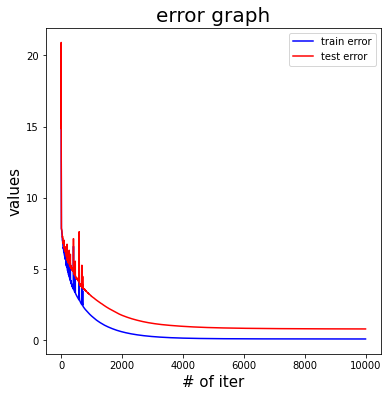

In [70]:
plt.figure(figsize = (6,6))
plt.title("error graph",fontsize = 20)
plt.xlabel("# of iter",fontsize = 15)
plt.ylabel("values", fontsize = 15)
plt.plot(train_energy_val,c = "b",label = "train error")
plt.plot(test_energy_val,c = "r",label = "test error")
plt.legend(loc = "best")
plt.show()

# **Plot the accuracy curve**

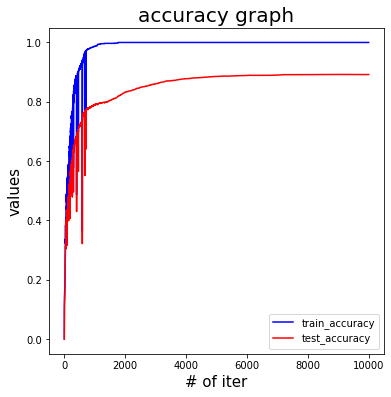

In [71]:
plt.figure(figsize = (6,6))
plt.title("accuracy graph",fontsize = 20)
plt.xlabel("# of iter",fontsize = 15)
plt.ylabel("values", fontsize = 15)
plt.plot(train_accu_val,c = "b",label = "train_accuracy")
plt.plot(test_accu_val,c = "r",label = "test_accuracy")
plt.legend(loc = "best")
plt.show()

# **Print the accuracy value**

In [0]:
print("final training accuracy : {}%".format(train_accu_val[-1]*100))
print("final test accuracy : {}%".format(test_accu_val[-1]*100))

# **Plot the classification example : Correct**

In [0]:
plt.figure(figsize = (10,5))
idx = np.where(test_pred == Y_test)[0][:10]
size_row = 28
size_col = 28
count = 1
for i in idx:
    label       = Y_test[i]
    im_vector   = X_test[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(2, 5, count)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    count+=1
plt.show()

# **Plot the classification example : misclassified**

In [0]:
plt.figure(figsize = (10,5))
idx = np.where(test_pred != Y_test)[0][:10]
size_row = 28
size_col = 28
count = 1
for i in idx:
    pred      = test_pred[i]
    actual    = Y_test[i]
    im_vector   = X_test[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(2, 5, count)
    plt.title("pred : {} true : {}".format(pred,actual))
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    count+=1
plt.show()